# Load & Process the play-by-play data for 2002 through 2012

http://archive.advancedfootballanalytics.com/2010/04/play-by-play-data.html

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import re
import time

In [5]:
plays = pd.DataFrame()
for i in range(2002,2013):
    year = str(i)
    plays = plays.append(pd.read_csv('data/'+year+'_nfl_pbp_data.csv'), ignore_index=True)

In [3]:
#plays = pd.read_csv('data/processed_plays.csv')
#For when I want to make small improvements without re-creating everything

/Users/jessegalef/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
plays.head()

,gameid,qtr,min,sec,off,def,down,togo,ydline,description,offscore,defscore,season
0,20020905_SF@NYG,1.0,NaN,0,SF,NYG,NaN,NaN,NaN,J.Cortez kicks 75 yards from SF 30 to NYG -5. ...,0.0,0.0,2002.0
1,20020905_SF@NYG,1.0,60.0,0,NYG,SF,1.0,10.0,80.0,(15:00) T.Barber left end to NYG 24 for 4 yard...,0.0,0.0,2002.0
2,20020905_SF@NYG,1.0,59.0,25,NYG,SF,2.0,6.0,76.0,(14:25) K.Collins pass incomplete to J.Shockey...,0.0,0.0,2002.0
3,20020905_SF@NYG,1.0,59.0,20,NYG,SF,3.0,6.0,76.0,(14:20) PENALTY on NYG-J.Shockey False Start ...,0.0,0.0,2002.0
4,20020905_SF@NYG,1.0,59.0,20,NYG,SF,3.0,11.0,81.0,(14:20) (Shotgun) K.Collins pass intended for ...,0.0,0.0,2002.0


In [7]:
plays['lead'] = plays.offscore - plays.defscore
plays.description = plays.description.astype(str)

plays['passAttempt'] = plays.description.apply(lambda x: 1 if ('pass' in x.lower() or 'sack' in x.lower() or 'incomplete' in x.lower()) else 0)
plays['incomplete'] = plays.description.apply(lambda x: 1 if 'incomplete' in x.lower() else 0)
plays['intercepted'] = plays.description.astype(str).apply(lambda x: 1 if 'intercept' in x.lower() else 0) 
# This doesn't cover penalties, but get that later

plays['sack'] = plays.description.apply(lambda x: 1 if 'sack' in x.lower() else 0)
plays['penalty'] = plays.description.apply(lambda x: 1 if (('penalty' in x.lower())&('declined' not in x.lower())) else 0)


In [8]:

def detect_rush(desc):
    desc = desc.lower()
    direction = re.search('\. ?\w+ (\w+)', desc)
    if direction != None: 
        if direction.group(1) in ['left', 'right','up','to', 'scrambles']: return 1
    return 0

plays['rushAttempt'] = plays.description.apply(detect_rush)

plays['playtype'] = "neither"
plays.ix[plays.rushAttempt==1, 'playtype'] = 'rush'
plays.ix[plays.passAttempt==1, 'playtype'] = 'pass'
plays.ix[plays.incomplete==1, 'playtype'] = 'incomplete'


In [9]:
plays.playtype.value_counts()

rush          154507
pass          138855
neither       104168
incomplete     76370
Name: playtype, dtype: int64

In [10]:
plays[(plays.rushAttempt==1)&(plays.passAttempt==1)].shape
# 1197 plays are counted as both pass and rush - usually a penalty or quarterback scramble.
# Sometimes the description says 'scramble' and other times it doesn't - I'm ok with this level
# of noise

(1197, 21)

In [11]:
plays['nextoff'] = plays.off.shift(-1)
plays['nextdown'] = plays.down.shift(-1)
plays['nexttogo'] = plays.togo.shift(-1)
plays['nextpenalty'] = plays.penalty.shift(-1)
plays['nextoff'] = plays.off.shift(-1)

plays['nextrushAttempt'] = plays.rushAttempt.shift(-1)
plays['nextpassAttempt'] = plays.passAttempt.shift(-1)
plays['nextplaytype'] = plays.playtype.shift(-1)

def yards_net(desc):
    desc = desc.lower()
    while 'reversed' in desc:
        desc = desc[desc.find('reversed')+len('reversed')]
    for verb in ['aborted', 'intercept','field goal','punt','kick', 'extra point', 'conversion']:
        if verb in desc: return np.nan
    if 'spike' in desc: return -1 # I hope this is a fair assumption
    num= re.search('(-?[0-9]+?) yard', desc)
    if num == None:
        if ('no gain' in desc) | ('incomplete' in desc): return 0
#         print desc # This was for debugging purposes
        return np.nan
    else:
        num = int(num.group(1))
        if ('sack' in desc) | ('loss of' in desc)| (('penalty' in desc)&('decline' not in desc)&('between downs' not in desc)):
            return -abs(num)
        else:
            return num
    return np.nan


plays['ydsnet'] = plays.description.astype(str).apply(yards_net)
plays['nextydsnet'] = plays.ydsnet.shift(-1)


In [12]:

plays['prevIncomplete'] = plays.incomplete.shift(1)
plays['prevYdline'] = plays.ydline.shift(1)
plays['prevoff'] = plays['off'].shift(1)
plays['prevdown'] = plays.down.shift(1)

plays['prevYdsnet'] = plays.ydsnet.shift(1)
plays['prevtogo'] = plays.togo.shift(1)
plays['prevrushAttempt'] = plays.rushAttempt.shift(1)
plays['prevpassAttempt'] = plays.passAttempt.shift(1)
plays['prevplaytype'] = plays.playtype.shift(1)
plays['prevpenalty'] = plays.penalty.shift(1)
plays['switch'] = plays.prevrushAttempt != plays.rushAttempt

plays['passYards'] = plays['ydsnet'] * plays['passAttempt']
plays['rushYards'] = plays['ydsnet'] * plays['rushAttempt']



## Previous Season stats

In [13]:
%%time
# prev_season_rush_percent = plays[plays.down<=3].groupby(['off', 'season']).mean()[['rushAttempt']]
for team in plays.off.unique():
    for season in plays.season.unique():
        prev_season = max(2002,season-1) 
        # Since I have no data for 2001, I use the 2002's own values to approximate
        # This is suspect and it might be better to impute them in some manner

        # May the statistics gods forgive me.
        
        plays.ix[(plays.off==team)&(plays.season==season), 'prev_season_rush_percent'] = plays[(plays.off==team)&(plays.season==prev_season)].rushAttempt.mean()
        plays.ix[(plays['def']==team)&(plays.season==season), 'def_prev_season_rush_percent'] = plays[(plays['def']==team)&(plays.season==prev_season)].rushAttempt.mean()
        plays.ix[(plays.off==team)&(plays.season==season), 'prev_season_rush_ydsnet_average'] = plays[(plays.off==team)&(plays.season==prev_season)&(plays.rushAttempt==1)].ydsnet.mean()
        plays.ix[(plays.off==team)&(plays.season==season), 'prev_season_pass_ydsnet_average'] = plays[(plays.off==team)&(plays.season==prev_season)&(plays.passAttempt==1)].ydsnet.mean()
        plays.ix[(plays['def']==team)&(plays.season==season), 'def_prev_season_rush_ydsnet_average'] = plays[(plays['def']==team)&(plays.season==prev_season)&(plays.rushAttempt==1)].ydsnet.mean()
        plays.ix[(plays['def']==team)&(plays.season==season), 'def_prev_season_pass_ydsnet_average'] = plays[(plays['def']==team)&(plays.season==prev_season)&(plays.passAttempt==1)].ydsnet.mean()
        plays.ix[(plays.off==team)&(plays.season==season), 'prev_season_incompletion_percent'] = plays[(plays.off==team)&(plays.season==prev_season)&(plays.passAttempt == 1)].incomplete.mean()
        plays.ix[(plays['def']==team)&(plays.season==season), 'def_prev_season_incompletion_percent'] = plays[(plays['def']==team)&(plays.season==prev_season)&(plays.passAttempt==1)].incomplete.mean()


plays['prev_season_offense_pass_yard_adv'] = plays['prev_season_pass_ydsnet_average'] - plays['def_prev_season_pass_ydsnet_average']
plays['prev_season_offense_rush_yard_adv'] = plays['prev_season_rush_ydsnet_average'] - plays['def_prev_season_rush_ydsnet_average']
plays['pass_comparative_adv'] = plays['prev_season_offense_pass_yard_adv'] - plays['prev_season_offense_rush_yard_adv']

CPU times: user 8min 56s, sys: 18.3 s, total: 9min 15s
Wall time: 10min 6s


## This season up to now stats

In [52]:

count = 0
t0 = time.time()
for team in plays.off.unique():
    for season in plays.season.unique():
        count = count + 1
        if count % 50 == 0:
            print count, time.time() - t0

        # In order to avoid division by zero, I considered adding one to the denominator, which
        # ends up giving predictive models too much information - if the first plays are passes, average rushing yards
        # is zero and the model can be very confident the previous plays were passes.

        # Instead, I'm adding one rush & pass that gained the team's previous season's average net yard.
        # (for incompletion percent, I'm adding the previous season's incompletion percent to the nominator and 1 to the denominator)
            
        season_team_df = plays[(plays.off == team)&(plays.season == season)]
        number_of_rushes_plus_one = season_team_df.rushAttempt.cumsum().shift(1).fillna(0) + 1
        number_of_passes_plus_one = season_team_df.passAttempt.cumsum().shift(1).fillna(0) + 1

        
        plays.ix[season_team_df.index, 'cumulative_season_incompletion_percent'] = (plays.ix[season_team_df.index, 'incomplete'].cumsum().shift(1).fillna(0) +
                                                                                    plays.ix[season_team_df.index, 'prev_season_incompletion_percent'])/ number_of_passes_plus_one
        
        
        plays.ix[season_team_df.index, 'cumulative_season_rush_yards']= season_team_df.rushYards.cumsum().shift(1).fillna(0)
        plays.ix[season_team_df.index, 'cumulative_season_rush_average'] = (plays.ix[season_team_df.index, 'cumulative_season_rush_yards'] + plays.ix[season_team_df.index, 'prev_season_rush_ydsnet_average']) / number_of_rushes_plus_one
        
        plays.ix[season_team_df.index, 'cumulative_season_pass_yards']= season_team_df.passYards.cumsum().shift(1).fillna(0)
        plays.ix[season_team_df.index, 'cumulative_season_pass_average'] = (plays.ix[season_team_df.index, 'cumulative_season_pass_yards'] + plays.ix[season_team_df.index, 'prev_season_pass_ydsnet_average']) / number_of_passes_plus_one


plays['cumulative_season_incompletion_percent'].fillna(0,inplace=True)
plays['cumulative_season_rush_yards'].fillna(0,inplace=True)
plays['cumulative_season_rush_average'].fillna(0,inplace=True)
plays['cumulative_season_pass_yards'].fillna(0,inplace=True)
plays['cumulative_season_pass_average'].fillna(0,inplace=True)

50 7.71403598785
100 15.8557698727
150 23.3103609085
200 31.3258259296
250 39.5116090775
300 46.8024709225
350 53.3494720459


## This game up to now stats

In [53]:
%%time
count = 0
t0=time.time()
# print "Total number of team/game combinations: ", len(plays.gameid.unique())*2
for game in plays.gameid.unique():
    for team in plays[plays.gameid == game]['off'].unique():
        count +=1
        if count%100==0: 
            print count, (time.time() - t0)/60., ' minutes'
        game_team_df = plays[(plays.gameid == game)&(plays.off == team)]
        plays.ix[game_team_df.index, 'cumulative_rush_yards']= game_team_df.rushYards.cumsum().shift(1)
        plays.ix[game_team_df.index, 'cumulative_pass_yards']= game_team_df.passYards.cumsum().shift(1)
        
        number_of_rushes_plus_one = game_team_df.rushAttempt.cumsum().shift(1).fillna(0) + 1
        number_of_passes_plus_one = game_team_df.passAttempt.cumsum().shift(1).fillna(0) + 1

        plays.ix[game_team_df.index, 'cumulative_mean_rush_yards'] = (plays.ix[game_team_df.index, 'cumulative_rush_yards'] + plays.ix[game_team_df.index, 'cumulative_season_rush_average']) / number_of_rushes_plus_one                                                                      
        plays.ix[game_team_df.index, 'cumulative_mean_pass_yards'] = (plays.ix[game_team_df.index, 'cumulative_pass_yards'] + plays.ix[game_team_df.index, 'cumulative_season_pass_average']) / number_of_passes_plus_one
        plays.ix[game_team_df.index, 'cumulative_incompletion_percent'] = (game_team_df.incomplete.cumsum().shift(1).fillna(0) + game_team_df.cumulative_season_incompletion_percent) / number_of_passes_plus_one

100 0.513027934233  minutes
200 1.07461178303  minutes
300 1.55073531469  minutes
400 2.10046986739  minutes
500 2.71330634753  minutes
600 3.4666520675  minutes
700 4.46464219888  minutes
800 5.31489789883  minutes
900 6.21528999805  minutes
1000 7.12336596648  minutes
1100 7.94950791597  minutes
1200 8.81547385057  minutes
1300 9.49435428381  minutes
1400 10.0467156172  minutes
1500 10.6402755658  minutes
1600 11.6065272331  minutes
1700 13.0305974841  minutes
1800 13.9603655974  minutes
1900 14.5460682829  minutes
2000 15.5715805332  minutes
2100 16.2602764805  minutes
2200 16.8137724638  minutes
2300 17.3972961664  minutes
2400 17.8798504829  minutes
2500 18.3869715651  minutes
2600 18.9882703821  minutes
2700 19.5895814975  minutes
2800 20.2130103827  minutes
2900 20.7125447472  minutes
3000 21.3230306149  minutes
3100 21.7985897501  minutes
3200 22.2970364491  minutes
3300 23.0071259141  minutes
3400 23.4750231663  minutes
3500 23.9449825486  minutes
3600 24.498573633  minutes
37

In [55]:
plays.cumulative_rush_yards.fillna(0, inplace=True)
plays.cumulative_pass_yards.fillna(0, inplace=True)
plays.cumulative_mean_rush_yards.fillna(0, inplace=True)
plays.cumulative_mean_pass_yards.fillna(0, inplace=True)
plays.cumulative_incompletion_percent.fillna(0, inplace=True)


In [56]:
plays['hurrying'] = ((plays.qtr==2)&(plays['min']<=34)) | ((plays.qtr==4)&(plays.lead<=0)&(plays['min']<=4))
plays['runOutClock'] = ((plays.lead>0)&(plays['min'] <=4))

plays['timeunder'] = (plays['min']-1) % 15

plays['timehalf'] = (plays['min']-1) % 30



In [57]:
plays.to_csv('data/processed_plays.csv')

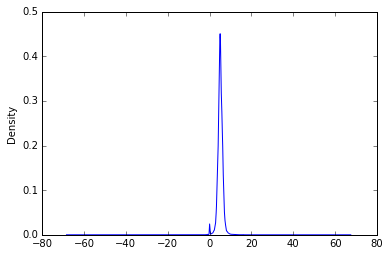

In [58]:
plays[plays.down==2].cumulative_season_pass_average.plot(kind='kde')